<a href="https://colab.research.google.com/github/Akechi1412/Vietnamese-Review-Classification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Akechi1412/Vietnamese-Review-Classification
%cd Vietnamese-Review-Classification

fatal: destination path 'Vietnamese-Review-Classification' already exists and is not an empty directory.
/content/Vietnamese-Review-Classification


In [3]:
!pip install pyvi https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz --upgrade

  Using cached https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz (233.3 MB)
  Preparing metadata (setup.py) ... done


In [5]:
!git pull origin master

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7 (delta 5), reused 7 (delta 5), pack-reused 0
Unpacking objects: 100% (7/7), 1.06 KiB | 13.00 KiB/s, done.
From https://github.com/Akechi1412/Vietnamese-Review-Classification
 * branch            master     -> FETCH_HEAD
   4d7781e..39b665a  master     -> origin/master
Updating 4d7781e..39b665a
Fast-forward
 data/reviews_data.csv   | 3 +++
 test.py                 | 5 +++--
 utils/data_preparing.py | 4 +++-
 3 files changed, 9 insertions(+), 3 deletions(-)


Data size: 9003
Max number of words: 476
['đọc', 'cuốn', 'sách', 'tập', '1', 'mình', 'đã', 'nhận', 'ra', 'những', 'điều', 'thiếu sót', 'trong', 'quá trình', 'quản trị', 'doanh nghiệp', 'của', 'mình', 'chưa', 'có', 'tầm', 'nhìn', 'sứ mệnh', 'và', 'các', 'giá trị', 'cốt lõi', 'dẫn', 'đến', 'lúng túng', 'và', 'không thể', 'vận hành', 'doanh nghiệp', '1', 'cách', 'trơn tru', 'trong', 'sách', 'còn', 'có', 'nhiều', 'quà', 'tặng', 'đi', 'kèm', 'cực', 'giá trị', 'mình', 'đọc', 'mà', 'quên', 'cả', 'ăn', 'luôn', 'đúng', 'là', 'cuốn', 'sách', 'giá trị', 'trong', 'các', 'cuốn', 'sách', 'mình', 'đã', 'từng', 'đọc']
0


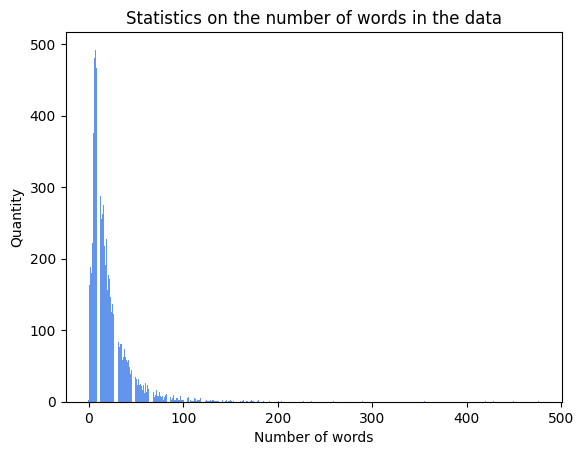

In [8]:
from utils.data_preparing import prepare_data
from utils.plotter import plot_reviews_data

x_data, y_data = prepare_data()

print(f'Data size: {len(x_data)}')
print(f'Max number of words: {len(max(x_data, key=len))}')
print(x_data[0])
print(y_data[0])

plot_reviews_data(x_data)